In [19]:
import pandas as pd
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt

from scipy.misc import imsave
from imageio import imwrite, imread
from tqdm import tqdm
from skimage import *
import itertools

import keras
from keras.preprocessing import image

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV


# !pip install tqdm --user

In [3]:
%run '/gpfs/cbica/home/santhosr/Codes/utils.py'

In [4]:
numSamples0 = 200
numSamples1 = 200

X0 = []
X1 = []

baseDir0 = '/gpfs/cbica/home/santhosr/Datasets/jpeg/0'
baseDir1 = '/gpfs/cbica/home/santhosr/Datasets/jpeg/1'

# Non Cancer images
fileList = os.listdir(baseDir0)
np.random.shuffle(fileList)
fileList = fileList[:numSamples0]

for i in tqdm(range(numSamples0)):
    img = read_img(os.path.join(baseDir0,fileList[i]),(225,225))
    img = img.reshape((img.shape[0]*img.shape[1],))
    X0.append(img)
    
    
# Cancer images
fileList = os.listdir(baseDir1)
np.random.shuffle(fileList)
fileList = fileList[:numSamples1]

for i in tqdm(range(numSamples1)):
    img = read_img(os.path.join(baseDir1,fileList[i]),(225,225))
    img = img.reshape((img.shape[0]*img.shape[1],))
    X1.append(img)



100%|██████████| 200/200 [00:17<00:00, 13.03it/s]


In [5]:
X0 = np.array(X0)
X1 = np.array(X1)


In [6]:
def shuffleCombineData(x0,x1):
    
    e = [(x,0) for x in x0]
    f = [(x,1) for x in x1]
    e = e+f
    
    np.random.shuffle(e)
    
    X = np.array([x[0] for x in e])
    y = [x[1] for x in e]
    
    return X,y

In [7]:
X,y =shuffleCombineData(X0,X1)

In [8]:
X.shape

(400, 50625)

In [11]:
pcaModel = PCA(n_components=150)
pcaModel.fit(X)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
np.sum(pcaModel.explained_variance_ratio_)

0.9941159

In [13]:
pcaX = pcaModel.transform(X)

In [14]:
pcaX.shape

(400, 150)

In [15]:
trainx,testx,trainy,testy = train_test_split(pcaX,y,test_size = 0.1)

### Random Forest

In [42]:
rfModel = RandomForestClassifier(n_estimators=1000,max_depth=6, min_samples_leaf=4)

# rfModel = RandomForestClassifier()

In [43]:
rfModel.fit(trainx,trainy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Confusion matrix, without normalization
[[11  6]
 [13 10]]
Accuracy - Train : 1.0  Test : 0.525
F1 Score - Train : 1.0  Test : 0.512820512821
----------------------


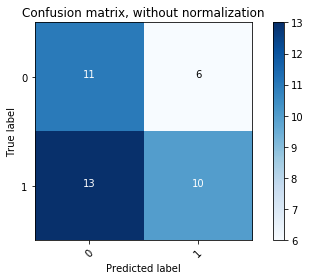

In [44]:
printResults(rfModel,trainx,trainy,testx,testy)

In [151]:
accuracy_score(testy,pred)

0.575

In [152]:
f1_score(testy,pred)


0.5142857142857143

In [153]:
cv = cross_val_score(rfModel,pcaX,y,cv=5,scoring='accuracy')

In [154]:
cv

array([0.55, 0.51, 0.6 , 0.51, 0.6 ])

In [35]:
param_grid = {"n_estimators": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

param_grid = {"n_estimators": [500,1000],
              "max_depth":[10,15]
              }

In [36]:
grid_search = GridSearchCV(rfModel, param_grid=param_grid, cv=5)

In [37]:
grid_search.fit(trainx,trainy)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 1000], 'max_depth': [10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
grid_search.grid_scores_

/cbica/software/external/python/anaconda/2/envs/default/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.55278, std: 0.01380, params: {'n_estimators': 500, 'max_depth': 10},
 mean: 0.53333, std: 0.05015, params: {'n_estimators': 1000, 'max_depth': 10},
 mean: 0.52222, std: 0.03722, params: {'n_estimators': 500, 'max_depth': 15},
 mean: 0.53889, std: 0.04496, params: {'n_estimators': 1000, 'max_depth': 15}]